# Import packages and data 

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import scipy.stats
import anndata
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.axes._axes import _log as matplotlib_axes_logger
from scipy import sparse
matplotlib_axes_logger.setLevel('ERROR')

/Users/b8058304/.pyenv/versions/3.6.4/envs/py36/lib/python3.6/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


In [2]:
sc.settings.verbosity = 1  # verbosity: errors (0), warnings (1), info (2), hints (3)
# Set up the plot config for viewing the annotation clearly.
sc.settings.set_figure_params(dpi=120, dpi_save=1000)
sc.logging.print_versions()

scanpy==1.4.4 anndata==0.7.1 umap==0.3.10 numpy==1.17.1 scipy==1.4.1 pandas==1.0.5 scikit-learn==0.22.2.post1 statsmodels==0.11.1 python-igraph==0.8.0 louvain==0.6.1


# Load FL GMP

In [3]:
adata = sc.read('/Users/b8058304/Documents/PhD_work/Coding/liver/data/fetal_liver_alladata_Copy1.h5ad')

In [4]:
adata.raw = adata

In [5]:
adata.obs["tissue"] = "liver"

In [6]:
cell_numbers = adata.obs.groupby(["cell.labels"]).apply(len)
cell_numbers

cell.labels
B cell                            1079
DC1                                336
DC2                               3954
DC precursor                       330
Early Erythroid                  11985
Early lymphoid_T lymphocyte        767
Endothelial cell                  3348
Fibroblast                        1713
HSC_MPP                           3439
Hepatocyte                        2479
ILC precursor                     1726
Kupffer Cell                     24841
Late Erythroid                    3180
MEMP                              1342
Mast cell                         1308
Megakaryocyte                     3983
Mid Erythroid                    27000
Mono-Mac                          6590
Monocyte                          2586
Monocyte precursor                 350
NK                                6706
Neutrophil-myeloid progenitor      658
Pre pro B cell                     234
VCAM1+ EI macrophage               161
pDC precursor                      253
pre-B cell   

In [7]:
adata = adata[adata.obs['cell.labels_progen'].isin(['GMP'])].copy()

In [8]:
cell_numbers = adata.obs.groupby(['cell.labels_progen']).apply(len)
cell_numbers

cell.labels_progen
GMP    362
dtype: int64

In [9]:
adata.obs["cell.labels"] = "GMP"

In [10]:
adata.obs["tissue"] = "liver"
adata.obs["tissue_cell.labels"] = adata.obs["tissue"].astype(str) + '_' + adata.obs["cell.labels"].astype(str)

In [11]:
cell_numbers = adata.obs.groupby(["tissue_cell.labels"]).apply(len)
cell_numbers

tissue_cell.labels
liver_GMP    362
dtype: int64

In [12]:
liver = adata

# Load FBM neut myeloid

In [13]:
adata = sc.read('/Users/b8058304/Documents/PhD_work/Coding/bm_plus_19pcw/data/bm_plus_19pcw_raw_dr_20200713.h5ad')

In [14]:
adata.raw = adata

In [15]:
cell_numbers = adata.obs.groupby(["cell.labels"]).apply(len)
cell_numbers

cell.labels
CD4 T cell             327
CD8 T cell             171
CD14 monocyte         8787
CD56 bright NK         540
CMP                    425
                      ... 
schwann cells            9
sinusoidal EC          550
stromal macrophage    1493
tDC                    193
tip EC                 363
Length: 64, dtype: int64

In [16]:
adata.obs["tissue"] = "fbm"

In [17]:
adata = adata[adata.obs['cell.labels'].isin(['GMP'])].copy()

In [18]:
cell_numbers = adata.obs.groupby(["cell.labels"]).apply(len)
cell_numbers

cell.labels
GMP    1285
dtype: int64

In [19]:
adata.obs["tissue"] = "fbm"
adata.obs["tissue_cell.labels"] = adata.obs["tissue"].astype(str) + '_' + adata.obs["cell.labels"].astype(str)

In [20]:
cell_numbers = adata.obs.groupby(["tissue_cell.labels"]).apply(len)
cell_numbers

tissue_cell.labels
fbm_GMP    1285
dtype: int64

In [21]:
fbm = adata

# Merge the GMP datasets

In [22]:
merged = liver.concatenate(fbm, index_unique=None, join='outer')

In [23]:
merged.shape

(1647, 33713)

In [24]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
cell_numbers = merged.obs.groupby(["tissue_cell.labels"]).apply(len)
cell_numbers

tissue_cell.labels
fbm_GMP      1285
liver_GMP     362
dtype: int64

In [25]:
merged

AnnData object with n_obs × n_vars = 1647 × 33713 
    obs: 'AnnatomicalPart', 'april_cell.labels', 'batch', 'cell.labels', 'cell.labels_20200708', 'cell.labels_20200713', 'cell.labels_progen', 'combined.labels', 'doublets', 'fetal.ids', 'gender', 'is_doublet', 'is_doublet_poptrim', 'is_doublet_wolock', 'lanes', 'nGene', 'nUMI', 'n_counts', 'orig.ident', 'percent.mito', 'processing.type', 'sample', 'sample.type', 'scrublet_cluster_score', 'scrublet_score', 'sequencing.type', 'sort.ids', 'stages', 'tissue', 'tissue_cell.labels'
    var: 'gene_ids-1-1', 'feature_types-1-1'
    obsm: 'X_umap'

# Pre-process the datasets (no dimensional reduction)

In [26]:
adata = merged

In [27]:
adata.shape

(1647, 33713)

In [28]:
adata.X

<1647x33713 sparse matrix of type '<class 'numpy.float32'>'
	with 5952852 stored elements in Compressed Sparse Row format>

In [29]:
adata.X = np.nan_to_num(adata.X, copy=False)

In [30]:
adata.X

<1647x33713 sparse matrix of type '<class 'numpy.float32'>'
	with 5952852 stored elements in Compressed Sparse Row format>

In [31]:
# have a look at raw GEX values
#adata.X.toarray()

In [32]:
# Add 0.01 to all raw values to ensure that ratio can be run for cells with zero expression of one TF
#adata.X = adata.X.toarray() + 0.01
#adata.X

In [33]:
# normalise count data 
sc.pp.normalize_total(adata)

In [34]:
# log the count data 
sc.pp.log1p(adata)

In [35]:
# find variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5) 

In [36]:
# scale the data 
sc.pp.scale(adata, max_value=10)

In [37]:
# scale the negative values in adata.X (which have been normalised, logged and scaled) to zero 
adata.X = np.where(adata.X < 0, 0.01, adata.X)

# Save the transformed GEX for SPIB/CEBPA along with tissue and sample

In [38]:
metadata_df = pd.DataFrame(adata.obs[["tissue_cell.labels", "orig.ident"]])
metadata_df

,tissue_cell.labels,orig.ident
index,,
F45_liver_CD45-_FCAImmP7579223_CGTAGCGAGTACCGGA,liver_GMP,F45
F30_liver_CD45-_FCAImmP7277561_CTTAACTGTCGCGGTT,liver_GMP,F30
F34_liver_CD45-_FCAImmP7352195_CACACTCAGCTAGCCC,liver_GMP,F34
F45_liver_CD45+_FCAImmP7579210_GAACCTACAGTATCTG,liver_GMP,F45
F45_liver_CD45-_FCAImmP7579223_ACTGAACTCAGAGGTG,liver_GMP,F45
...,...,...
CCACGTTCAATACAGA-1-WSSS_F_BON8710642,fbm_GMP,SB19PCW
CGTTAGAAGGATCATA-1-WSSS_F_BON8710642,fbm_GMP,SB19PCW
GACTTCCTCTACGGGC-1-WSSS_F_BON8710642,fbm_GMP,SB19PCW


In [39]:
gex_df = pd.DataFrame(data=adata.X, index=adata.obs.index, columns=adata.var.index)
gex_df = gex_df[['SPIB','CEBPA']]
gex_df

,SPIB,CEBPA
index,,
F45_liver_CD45-_FCAImmP7579223_CGTAGCGAGTACCGGA,0.01,0.010000
F30_liver_CD45-_FCAImmP7277561_CTTAACTGTCGCGGTT,0.01,0.010000
F34_liver_CD45-_FCAImmP7352195_CACACTCAGCTAGCCC,0.01,0.010000
F45_liver_CD45+_FCAImmP7579210_GAACCTACAGTATCTG,0.01,0.675299
F45_liver_CD45-_FCAImmP7579223_ACTGAACTCAGAGGTG,0.01,0.010000
...,...,...
CCACGTTCAATACAGA-1-WSSS_F_BON8710642,0.01,0.617371
CGTTAGAAGGATCATA-1-WSSS_F_BON8710642,0.01,0.010000
GACTTCCTCTACGGGC-1-WSSS_F_BON8710642,0.01,0.010000


In [40]:
merged_df = gex_df.merge(metadata_df, left_index=True, right_index=True)
merged_df.to_csv('/Users/b8058304/Documents/PhD_work/Coding/manuscript_figs/resources_for_pipelines/gmp_spib_cebpa_expression_fl_fbm_20200715.csv')
merged_df

,SPIB,CEBPA,tissue_cell.labels,orig.ident
index,,,,
F45_liver_CD45-_FCAImmP7579223_CGTAGCGAGTACCGGA,0.01,0.010000,liver_GMP,F45
F30_liver_CD45-_FCAImmP7277561_CTTAACTGTCGCGGTT,0.01,0.010000,liver_GMP,F30
F34_liver_CD45-_FCAImmP7352195_CACACTCAGCTAGCCC,0.01,0.010000,liver_GMP,F34
F45_liver_CD45+_FCAImmP7579210_GAACCTACAGTATCTG,0.01,0.675299,liver_GMP,F45
F45_liver_CD45-_FCAImmP7579223_ACTGAACTCAGAGGTG,0.01,0.010000,liver_GMP,F45
...,...,...,...,...
CCACGTTCAATACAGA-1-WSSS_F_BON8710642,0.01,0.617371,fbm_GMP,SB19PCW
CGTTAGAAGGATCATA-1-WSSS_F_BON8710642,0.01,0.010000,fbm_GMP,SB19PCW
GACTTCCTCTACGGGC-1-WSSS_F_BON8710642,0.01,0.010000,fbm_GMP,SB19PCW


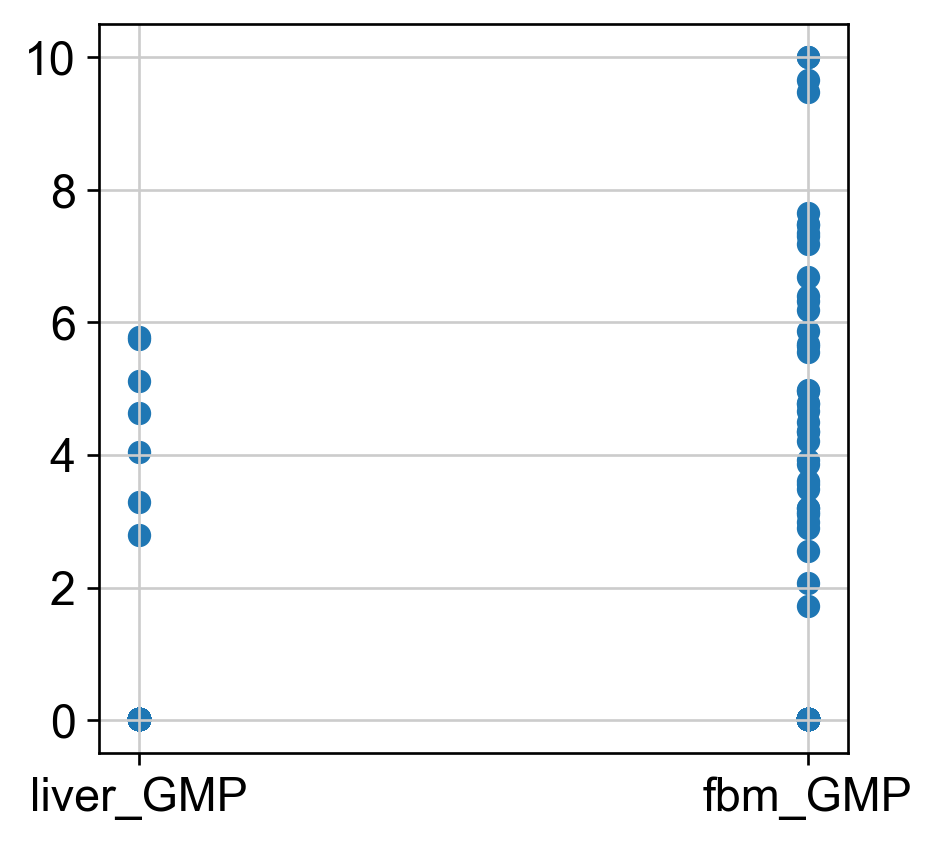

In [41]:
plt.scatter(merged_df["tissue_cell.labels"] ,merged_df["SPIB"])

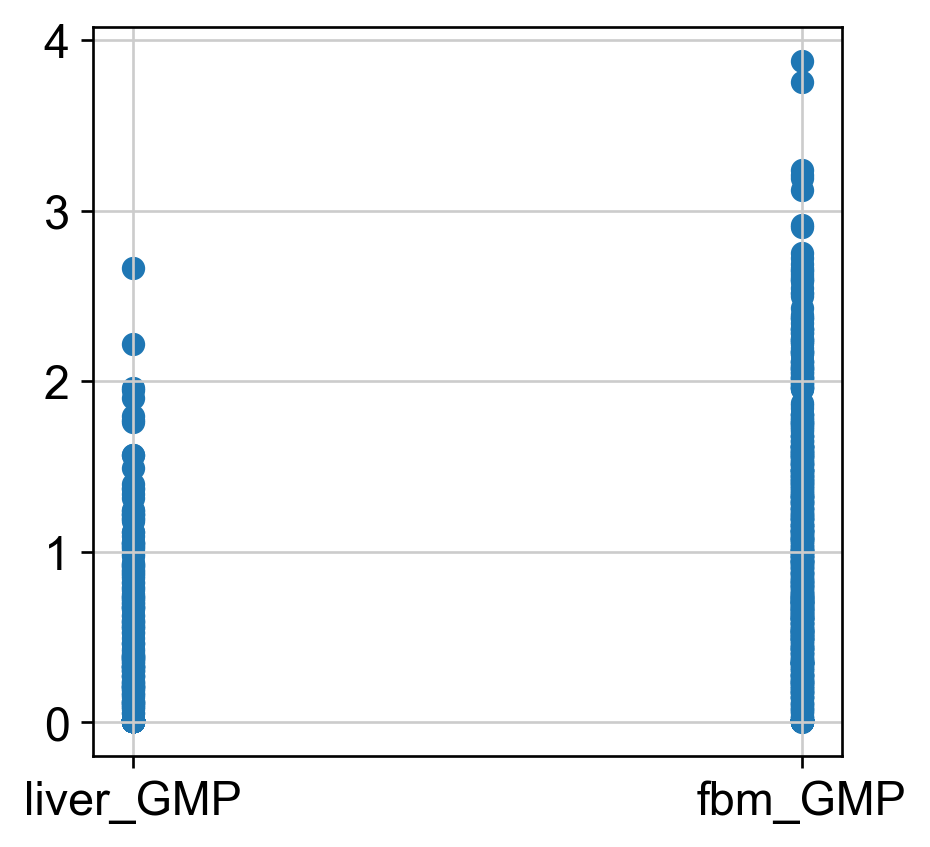

In [42]:
plt.scatter(merged_df["tissue_cell.labels"] ,merged_df["CEBPA"])

# Save the data

In [43]:
from scipy.sparse import csr_matrix
adata.X = sparse.csr_matrix(adata.X)

In [44]:
adata.X

<1647x33713 sparse matrix of type '<class 'numpy.float32'>'
	with 32994351 stored elements in Compressed Sparse Row format>

In [45]:
adata.raw.X

<1647x33713 sparse matrix of type '<class 'numpy.float32'>'
	with 5952852 stored elements in Compressed Sparse Row format>

In [46]:
adata.write("/Users/b8058304/Documents/PhD_work/Coding/manuscript_figs/data/fig2c_gmp_spib_cebpa_20200715.h5ad")

... storing 'AnnatomicalPart' as categorical
... storing 'april_cell.labels' as categorical
... storing 'cell.labels' as categorical
... storing 'cell.labels_20200708' as categorical
... storing 'cell.labels_20200713' as categorical
... storing 'cell.labels_progen' as categorical
... storing 'combined.labels' as categorical
... storing 'doublets' as categorical
... storing 'fetal.ids' as categorical
... storing 'gender' as categorical
... storing 'is_doublet' as categorical
... storing 'is_doublet_poptrim' as categorical
... storing 'is_doublet_wolock' as categorical
... storing 'lanes' as categorical
... storing 'orig.ident' as categorical
... storing 'processing.type' as categorical
... storing 'sample' as categorical
... storing 'sample.type' as categorical
... storing 'sequencing.type' as categorical
... storing 'sort.ids' as categorical
... storing 'stages' as categorical
... storing 'tissue' as categorical
... storing 'tissue_cell.labels' as categorical
... storing 'gene_ids-1-1'